# Data preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input, Lambda, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation,Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import os
from tensorflow.keras.losses import Loss
from keras_preprocessing import image

In [2]:
def read_data(dir, data):
    images1 = [] 
    images2 = [] 
    labels = []
    for j in range(0, len(data)):
        path = os.path.join(dir,data.iat[j, 0])
        img1 = cv2.imread(path)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img1 = cv2.resize(img1, (100, 100))
        images1.append([img1])
        path = os.path.join(dir, data.iat[j, 1])
        img2 = cv2.imread(path)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        img2 = cv2.resize(img2, (100, 100))
        images2.append([img2])
        labels.append(np.array(data.iat[j, 2]))
    images1 = np.array(images1).astype(np.float32) / 255.0
    images2 = np.array(images2).astype(np.float32) / 255.0
    labels = np.array(labels).astype(np.float32)
    return images1, images2, labels

In [3]:
train_dir ='./train'
train_csv ='./train_data.csv'
df_train = pd.read_csv(train_csv, header=None)
train_images1, train_images2, train_labels = read_data(dir=train_dir, data=df_train)
train_labels = to_categorical(train_labels)

In [4]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
for gpu in gpus:
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
size = 100
train_images1 = train_images1.reshape(-1, size, size, 1)
train_images2 = train_images2.reshape(-1, size, size, 1)

In [7]:
print(df_train.iloc[0, :])
img_org = df_train.iloc[0, 0]
img_frg = df_train.iloc[0, 1]

0             068/09_068.png
1    068_forg/03_0113068.PNG
2                          1
Name: 0, dtype: object


./train/068/09_068.png


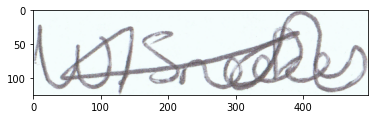

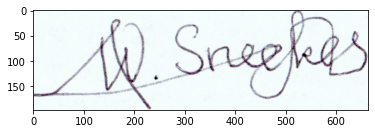

In [8]:
img_original = plt.imread('./train/'+img_org)
img_forged = plt.imread('./train/'+img_frg)

print('./train/'+img_org)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(img_original)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(img_forged)

# Simple Siamese Network

In [6]:
def initialize_base_network(input_shape):
    clf = Sequential()
    clf.add(Convolution2D(64, (3,3),input_shape=input_shape))
    clf.add(Activation('relu'))
    clf.add(MaxPooling2D(pool_size=(2, 2)))
    clf.add(Convolution2D(32, (3,3)))
    clf.add(Activation('relu'))
    clf.add(MaxPooling2D(pool_size=(2, 2)))
    clf.add(Flatten())
    clf.add(Dense(128, activation='relu'))
    clf.add(Dense(64, activation='relu'))
    return clf
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [7]:
input_dim = (100, 100, 1)
base_network = initialize_base_network(input_dim)
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
vec_a = base_network(img_a)
vec_b = base_network(img_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vec_a, vec_b])
prediction = Dense(2, activation='softmax')(distance)
model = Model([img_a, img_b], prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 64)           2194272     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=1,restore_best_weights=True)
callbacks_list =[early_stopping]

In [9]:
adam = tf.keras.optimizers.Adam(learning_rate=0.00008)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model.fit([train_images1,train_images2],train_labels,validation_split=.30,batch_size=32,epochs=1000,callbacks=callbacks_list)

Epoch 1/1000
508/508 [==============================] - 39s 49ms/step - loss: 0.6770 - accuracy: 0.5622 - val_loss: 0.7152 - val_accuracy: 0.4984
Epoch 2/1000
508/508 [==============================] - 24s 48ms/step - loss: 0.6567 - accuracy: 0.5622 - val_loss: 0.7183 - val_accuracy: 0.4984
Epoch 3/1000
508/508 [==============================] - 24s 48ms/step - loss: 0.6480 - accuracy: 0.5622 - val_loss: 0.7174 - val_accuracy: 0.4981
Epoch 4/1000
508/508 [==============================] - 24s 48ms/step - loss: 0.6428 - accuracy: 0.5634 - val_loss: 0.7213 - val_accuracy: 0.4971
Epoch 4: early stopping


In [12]:
from PIL import Image

In [15]:
img_org = df_train.iloc[0, 0]
img_frg = df_train.iloc[0, 1]
img_original = './train/'+img_org
img_forged = './train/'+img_frg

# x = image.load_img(img_original, target_size=(100, 100))    
# x = image.img_to_array(x)
# x = tf.image.rgb_to_grayscale(x)
# x = np.expand_dims(x, axis=0)
# x = x/255.0

# y = image.load_img(img_forged, target_size=(100, 100))    
# y = image.img_to_array(y)
# y = tf.image.rgb_to_grayscale(y)
# y = np.expand_dims(y, axis=0)
# y = y/255.0

img = Image.open(img_original).convert('L')
x = np.array(img.resize((100,100)))
x = x.reshape(1,100,100,1)
x = x/255.0

img1 = Image.open(img_forged).convert('L')
y = np.array(img.resize((100,100)))
y = y.reshape(1,100,100,1)
y = y/255.0

y_pred = model.predict([x,y])
print(y_pred)
y_pred = np.argmax(y_pred)
print(y_pred)
if y_pred==1:
  print('Forged')
else:
  print('Real')

1/1 [==============================] - 0s 35ms/step
[[0.50208116 0.49791884]]
0
Real


In [22]:
model.save('my_model1')

INFO:tensorflow:Assets written to: my_model1\assets


INFO:tensorflow:Assets written to: my_model1\assets


In [41]:
model_architecture = model.to_json()
model.save_weights('./my_model.h5')

In [42]:
import numpy as np
from tensorflow import keras
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.models import model_from_json

In [46]:
K

<module 'keras.api._v2.keras.backend' from 'c:\\Users\\divve\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\keras\\api\\_v2\\keras\\backend\\__init__.py'>

In [45]:
model1 = keras.models.load_model("./my_model.h5",custom_objects={"K":K})
# model1 = model_from_json(model_architecture)
# model1.load_weights('./my_model.h5')

x = image.load_img('../real.jpeg', target_size=(100, 100))    
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0

y = image.load_img('../forgid.jpeg', target_size=(100, 100))    
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0

y_pred = model1.predict([x,y])
y_pred = np.argmax(y_pred)

if y_pred==1:
    result = 'Forged'
else:
    result = 'Real'

print(result)

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x0000018D7FE73190>.